# **Building Advanced Transformers**

**Learning objectives:** 

By the end of this lab, you will be able to:

- Understand the core components of a Transformer architecture.
- Implement a multi-head self-attention mechanism from scratch.
- Train and evaluate a Transformer for time series prediction.
- Handle preprocessing and scaling for time series data effectively.


## What is a Transformer?

The Transformer architecture was introduced in the paper *"Attention Is All You Need"*. It revolutionized natural language processing by using attention mechanisms instead of recurrence.

### Key Components:
- **Input Embedding:** Converts input tokens (or time steps) into vectors.
- **Positional Encoding:** Injects information about the position of input tokens.
- **Multi-Head Self-Attention:** Allows the model to focus on different parts of the input sequence.
- **Feedforward Layers:** Process the attended information.
- **Layer Normalization & Residual Connections:** Stabilize and speed up training.

> Transformers are now widely used not only in NLP but also in time series forecasting, image recognition, and more.

**Next:** You will implement parts of this architecture step-by-step.


## Step-by-Step Instructions: 

### Step 1: Import necessary libraries 

Before you start, you need to import the required libraries: TensorFlow and Keras. Keras is included within TensorFlow as `tensorflow.keras.`


In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

####  Setup the Environment to generate synthetic stock price data


In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)
data_length = 2000  
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")


Synthetic stock_prices.csv created and loaded.


In [3]:
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values 

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In the above code: 

`tensorflow` is the main library for machine learning in Python.  

`stock_prices.csv` is the data set that is loaded. 

`MinMaxScaler` method is used to normalize the data.  

`create_dataset`method is used to prepare the data for training. 


### Step 2: Implement Multi-Head Self-Attention 

Define the Multi-Head Self-Attention mechanism. 


In [4]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

 

In the above code: 

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. 

- The attention parameter computes the attention scores and weighted sum of the values. 

- The split_heads parameter splits the input into multiple heads for parallel attention computation. 

- The call method applies the self-attention mechanism and combines the heads. 


### Step 3: Implement Transformer block 

Define the Transformer block. 


In [5]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 


    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

In the above code:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.  

- Dropout is used to prevent overfitting. 

- The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.


### Step 4: Implement Encoder Layer 

Define the Encoder layer. 


In [6]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 



In the above code: 

- The EncoderLayer is similar to the TransformerBlock but is a reusable layer in the Transformer architecture. 

- It consists of a MultiHeadSelfAttention mechanism followed by a feedforward neural network. 

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer. 

- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization. 


### Step 5: Implement Transformer encoder 

Define the Transformer Encoder. 


In [7]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 

class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 

    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 


    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 


    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False) 
print(outputs.shape) 

(1, 100, 128)


In the above code: 

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture. 


### Step 6: Build and Compile the Transformer model 

Integrate the Transformer Encoder into a complete model for sequential data. 


In [8]:
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

model.compile(optimizer='adam', loss='mse') 

model.summary() 

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In the above code: 

- The Transformer Encoder model defines the necessary parameters, flattens the output, and ends with a dense layer to produce the final output.  

- The model is then compiled with the Adam optimizer and mean squared error loss. 


### Step 7: Train the Transformer model 

Train the model on the prepared dataset. 


In [9]:
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 11.7214
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.2410
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.2263
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.1495
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.1578
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1545
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1233
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1659
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.2389
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.1452
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.1064
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0915
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.1230
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.1012
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0829
Ep

In the above code: 

The model is trained on the normalized stock price data for 20 epochs with a batch size of 32. 


### Step 8: Evaluate and Make Predictions 

Evaluate the model's performance and make predictions on the dataset. 


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step


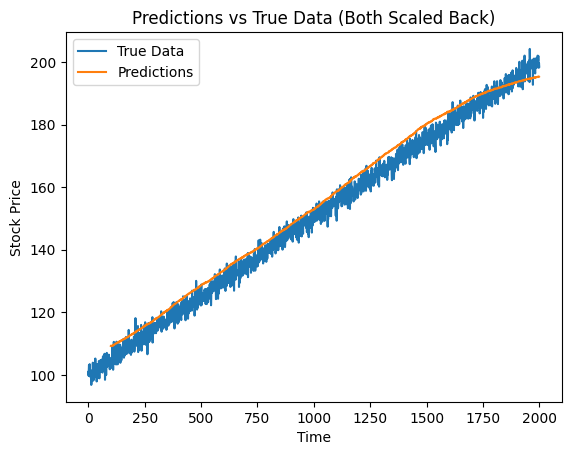

In [10]:
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

true_values = scaler.inverse_transform(data.reshape(-1, 1))

import matplotlib.pyplot as plt 

plt.plot(true_values, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show() 


In the above code: 

- The model's predictions are transformed back to the original scale using the inverse transform of the scaler. 

- The true data and predictions are plotted to visualize the model's performance. 


## Practice Exercises: 

 ### Exercise 1: Add dropout to the Transformer model 

 **Objective: Understand how to add dropout layers to the Transformer model to prevent overfitting.** 

 Instructions: 

- Add a dropout layer after the Flatten layer in the model. 

- Set the dropout rate to 0.5. 


In [11]:
from tensorflow.keras.layers import Dropout 

flatten = tf.keras.layers.Flatten()(encoder_outputs) 

dropout = Dropout(0.5)(flatten) 

outputs = tf.keras.layers.Dense(1)(dropout)  

model = tf.keras.Model(inputs, outputs) 

model.compile(optimizer='adam', loss='mse') 

model.fit(X, Y, epochs=20, batch_size=32) 

loss = model.evaluate(X, Y) 

print(f'Test loss: {loss}') 


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 340ms/step - loss: 7.0563
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - loss: 1.2571
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - loss: 0.7739
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - loss: 0.2820
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 305ms/step - loss: 0.1719
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - loss: 0.0761
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - loss: 0.0485
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 348ms/step - loss: 0.0370
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 301ms/step - loss: 0.0342
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - loss: 0.0210
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 345ms/step - loss: 0.0185
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 333ms/step - loss: 0.0164
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - loss: 0.0146
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 320ms/step - loss: 0.0164
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 

### Exercise 2: Experiment with different batch sizes 

**Objective: Observe the impact of different batch sizes on model performance.** 

 Instructions: 

- Train the model with a batch size of 16. 

- Train the model with a batch size of 64. 

- Compare the training time and performance. 


In [12]:
model.fit(X, Y, epochs=20, batch_size=16)

loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

model.fit(X, Y, epochs=20, batch_size=64)

loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 217ms/step - loss: 0.0221
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 46s 261ms/step - loss: 0.0328
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 240ms/step - loss: 0.0273
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - loss: 0.0261
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 244ms/step - loss: 0.0153
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - loss: 0.0186
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 229ms/step - loss: 0.0285
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 43s 243ms/step - loss: 0.0192
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - loss: 0.0227
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - loss: 0.0139
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - loss: 0.0159
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - loss: 0.0213
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - loss: 0.0222
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - loss: 0.0130
Epoch 15/20
119

### Exercise 3: Use a different activation function 

 **Objective: Understand how different activation functions impact the model performance.** 

 Instructions: 

- Change the activation function of the Dense layer to `tanh`. 

- Train and evaluate the model. 


In [13]:
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

model.fit(X, Y, epochs=20, batch_size=32)

loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 361ms/step - loss: 0.2843
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 339ms/step - loss: 0.2976
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - loss: 0.2882
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 275ms/step - loss: 0.2974
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - loss: 0.3061
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/step - loss: 0.2935
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - loss: 0.2982
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 339ms/step - loss: 0.2945
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - loss: 0.2999
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 351ms/step - loss: 0.2964
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 352ms/step - loss: 0.2976
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 378ms/step - loss: 0.2925
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - loss: 0.3027
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 373ms/step - loss: 0.2876
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 